In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import import_dataset, get_scores, classes, label2id
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset
import pickle
CLASSES = classes

In [5]:
classes

['dialogues',
 'dissertation',
 'enquiry',
 'essay',
 'history',
 'political discourses',
 'treatise']

In [24]:
def collect_dataset(seed, save_vect=False):
    
    # returns preprocessed train, test and essays in history test set; trained vectorizer
    
    vectorizer = TfidfVectorizer(max_features=5000)
    
    # main dataset
    dataset = import_dataset(seed)
    
    dataset['train'] = dataset['train'].filter(lambda line: line['labels']!=4)
    dataset['test'] = dataset['test'].filter(lambda line: line['labels']!=4)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    x_train = vectorizer.fit_transform(dataset['train']['text'])
    x_test = vectorizer.transform(dataset['test']['text'])
    
    # essays in history
    eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
    
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    if save_vect:
        with open('models/tfidf_vectorizer_nohist.pkl','wb') as f:
            pickle.dump(vectorizer, f)
    
    return x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, vectorizer

In [13]:
def run_model(model, 
              title, 
              data=(),
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False,
              test_eh=True):
    
    if not data:
        data = collect_dataset(seed)
    
    x_train, y_train, x_test, y_test, x_eh_test, y_eh_test, _ = data
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    if test_eh:
        eh_accuracy = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=False)
        print('Accuracy on essays in history: ', eh_accuracy)

    accuracy = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy)
                
    out = {'accuracy':accuracy,
           'pred':pred}
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df
    
    return out

In [14]:
data = collect_dataset(13)

Filter:   0%|          | 0/2476 [00:00<?, ? examples/s]

Filter:   0%|          | 0/310 [00:00<?, ? examples/s]

In [17]:
from sklearn.linear_model import LogisticRegression

Filter:   0%|          | 0/2476 [00:00<?, ? examples/s]

Filter:   0%|          | 0/310 [00:00<?, ? examples/s]

Accuracy on essays in history:  0.0
Accuracy: 0.708%
Training time: 2.267700433731079 s


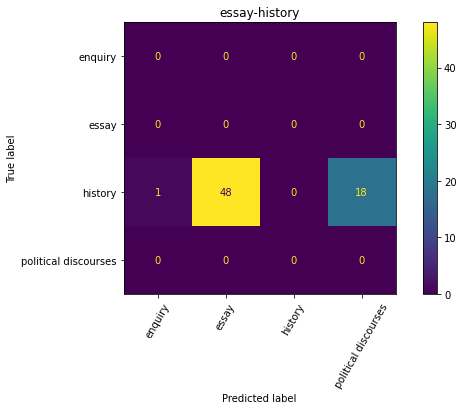

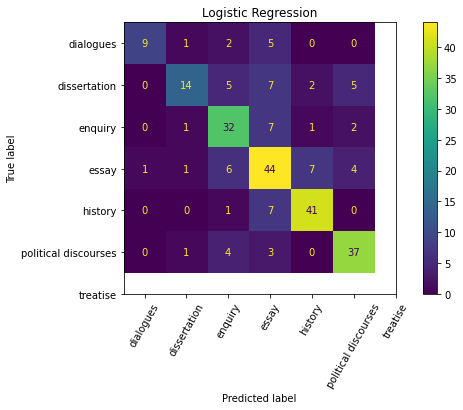

In [18]:
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression')
print(f'Training time: {time.time()-start} s')

In [20]:
logreg_proba = logreg_model.predict_proba(data[4]) # 67 x 7

In [23]:
with open('models/logreg_nohist.pkl','wb') as f:
    pickle.dump(logreg_model, f)

In [25]:
# save vectorizer
collect_dataset(13, save_vect=True)

Filter:   0%|          | 0/2476 [00:00<?, ? examples/s]

Filter:   0%|          | 0/310 [00:00<?, ? examples/s]

(<2081x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 178662 stored elements in Compressed Sparse Row format>,
 [3,
  2,
  5,
  6,
  2,
  2,
  5,
  0,
  6,
  2,
  2,
  0,
  6,
  1,
  5,
  6,
  1,
  6,
  5,
  5,
  0,
  6,
  3,
  0,
  6,
  1,
  3,
  2,
  5,
  3,
  2,
  3,
  3,
  3,
  6,
  1,
  2,
  3,
  6,
  3,
  6,
  1,
  3,
  5,
  1,
  6,
  6,
  5,
  0,
  2,
  6,
  3,
  2,
  3,
  6,
  2,
  5,
  5,
  6,
  2,
  2,
  0,
  0,
  3,
  2,
  6,
  3,
  6,
  0,
  1,
  6,
  2,
  6,
  2,
  0,
  5,
  6,
  3,
  0,
  3,
  3,
  3,
  6,
  3,
  3,
  1,
  2,
  5,
  1,
  6,
  0,
  6,
  3,
  6,
  3,
  2,
  3,
  5,
  3,
  6,
  6,
  6,
  6,
  0,
  2,
  0,
  6,
  6,
  6,
  5,
  5,
  5,
  2,
  3,
  2,
  2,
  2,
  3,
  0,
  0,
  3,
  6,
  1,
  0,
  2,
  0,
  2,
  2,
  5,
  5,
  2,
  0,
  2,
  2,
  5,
  0,
  3,
  2,
  0,
  6,
  3,
  1,
  2,
  6,
  1,
  5,
  6,
  5,
  5,
  0,
  5,
  2,
  0,
  5,
  2,
  6,
  5,
  5,
  5,
  1,
  3,
  3,
  2,
  2,
  6,
  5,
  2,
  3,
  3,
  0,
  2,
  6,
  2,
  3,
  0,
 

In [22]:
logreg_proba[0]

array([0.0596533 , 0.22755786, 0.1663063 , 0.31508653, 0.19869129,
       0.03270472])

In [21]:
sure = 0
unsure = 0

for line in logreg_proba:
    
    line = list(line)
    m = max(line) # first max
    ind = line.index(m)
    line.pop(ind)
    
    m2 = max(line) # second max
    ind2 = line.index(m2)
#     print(m, ind, m2, ind2)
    
    if m2 > 0.15: # if second max is more than treshold, the model is not super sure, and it is curious
        unsure += 1
    else:
        sure += 1

        
print(f'Sure: {sure}, unsure: {unsure}')

Sure: 2, unsure: 65
